# Reactive transport in granite simulation

In this tutorial, we show how Reaktoro can be used for one-dimensional reactive transport calculations for modeling
the geochemical reactions that occur along a porous rock column with granite as an acidic brine is continuously
injected on its left side.

## Import the reaktoro python package (and other packages)

First, we import the **reaktoro** Python package so that we can use its classes
and methods for performing the chemical reaction calculations.
> **Note**: Make sure that packages **matplolib**, *natsort**, and **progress**.

In [1]:
from reaktoro import *
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from natsort import natsorted

Setup properties or the plotting with the **matplolib** library:

In [2]:
mpl.set_loglevel("critical")
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'TeX Gyre Adventor'
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.unicode_minus'] = False

## Defining auxiliary time-related constants
In this step, we initialize auxiliary time-related constants from seconds to years. This is only done for
convenience, so that we can specify later, for example, fluid velocity as 1 m/week.

In [3]:
second = 1
minute = 60
hour = 60 * minute
day = 24 * hour
week = 7 * day

## Defining parameters for the reactive transport simulation

Next, we define reactive transport and numerical discretization parameters.

In [4]:
# Discretization parameters
xl = 0.0                # the x-coordinate of the left boundary
xr = 1.0                # the x-coordinate of the right boundary
ncells = 100            # the number of cells in the discretization
nsteps = 10000          # the number of steps in the reactive transport simulation
dt = 30*minute          # the time step (30 minutes in units of s)
dx = (xr - xl)/ncells   # length of the mesh cells (in units of m)

# Physical and chemical parameters
D = 1.0e-9             # the diffusion coefficient (in units of m2/s)
v = 1.0/week           # the fluid pore velocity (1 m/week in units of m/s)
T = 300.0               # the temperature (in units of degC)
# Calculate the water saturation pressure using the Wagner and Pruss (1995) equation of state
P = waterSaturatedPressureWagnerPruss(Temperature(T + 273.15)).val * 1e-5 # the pressure (in units of bar)
phi = 0.1               # the porosity

We specify the activity model for the aqueous species:

In [5]:
activity_model = "hkf-selected-species"

Define the names or the folders with resulting states as well as the plots illustrating time-dependent
behavior of chemical properties:

In [6]:
tag = "-dt-" + "{:d}".format(dt) + \
      "-ncells-" + str(ncells) + \
      "-nsteps-" + str(nsteps) + \
      "-" + activity_model
folder_results = 'results-rtsolver-granite' + tag
os.system('mkdir -p ' + folder_results)
folder_result_plots = "plots-" + folder_results
os.system('mkdir -p ' + folder_result_plots)

0

Generate the array with the number of time steps for the transport:

In [7]:
time_steps = np.linspace(0, nsteps, nsteps)

Next, we generate the coordinates of the mesh nodes (array `x`) by equally dividing the interval *[xr, xl]* with
the number of cells `ncells`. The length between each consecutive mesh nodes is computed and stored in `dx` (the
length of the mesh cells).

In [8]:
xcells = np.linspace(xl, xr, ncells)    # interval [xl, xr] split into `ncells`

To make sure that the applied finite-volume scheme is stable, we need to keep track of Courant–Friedrichs–Lewy (CFL)
number, which should be less than 1.0.

In [9]:
CFL = v*dt/dx
assert CFL <= 1.0, f"Make sure that CFL = {CFL} is less that 1.0"

## Reactive transport simulations

### Defining the chemical system

We need to define a chemical system that can represent both our fluid and rock. We use class
[ChemicalEditor](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalEditor.html) below to define a system with an
aqueous phase and twelve mineral phases.

In [10]:
editor = ChemicalEditor()

selected_elements = "Al Cl H K Na O Si"
selected_species = "H2O(l) H+ OH- Cl- HCl(aq) Na+ NaOH(aq) NaHSiO3(aq) NaCl(aq) " \
                    "K+ KOH(aq) KCl(aq) Al+++ AlOH++"

if activity_model == "pitzer-full":
    editor.addAqueousPhaseWithElements(selected_elements) \
        .setChemicalModelPitzerHMW() \
        .setActivityModelDrummondCO2()
elif activity_model == "hkf-full":
    editor.addAqueousPhaseWithElements(selected_elements)
elif activity_model == "dk-full":
    editor.addAqueousPhaseWithElements(selected_elements) \
        .setChemicalModelDebyeHuckel()
elif activity_model == "pitzer-selected-species":
    editor.addAqueousPhase(selected_species) \
        .setChemicalModelPitzerHMW() \
        .setActivityModelDrummondCO2()
elif activity_model == "hkf-selected-species":
    editor.addAqueousPhase(selected_species)
elif activity_model == "dk-selected-species":
    editor.addAqueousPhase(selected_species) \
        .setChemicalModelDebyeHuckel()

editor.addMineralPhase("Quartz") # SiO2
editor.addMineralPhase("Diaspore") # AlO(OH)
editor.addMineralPhase("Gibbsite") # Al(OH)3
editor.addMineralPhase("Andalusite") # Al2SiO5
editor.addMineralPhase("Kyanite") # Al2SiO5
editor.addMineralPhase("Sillimanite") # Al2SiO5
editor.addMineralPhase("Muscovite") # KAl2(AlSi3)O10(OH)2
editor.addMineralPhase("Paragonite") # NaAl2(AlSi3)O10(OH)2
editor.addMineralPhase("Pyrophyllite") # Al2Si4O10(OH)2
editor.addMineralPhase("Kaolinite") # Al2Si2O5(OH)4
editor.addMineralPhase("Albite") # Na(AlSi3)O8
editor.addMineralPhase("K-Feldspar") # K(AlSi3)O8


### Constructing the chemical system

This step is where we create an object of class
[ChemicalSystem](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalSystem.html) using the
chemical system definition details stored in the object ``editor``.

In [11]:
system = ChemicalSystem(editor)

### Initial condition for the fluid composition

Below, we define the **initial condition** for the fluid composition in the rock.

In [12]:
problem_ic = EquilibriumProblem(system)
problem_ic.setTemperature(T, 'celsius')
problem_ic.setPressure(P, 'bar')
problem_ic.add("H2O", 55.51, "mol") # H2O 55.51 M
problem_ic.add("NaCl", 0.27, "mol") # NaCl (aq) 0.27 M
problem_ic.add("KCl", 0.03, "mol") # KCl (aq)  0.03 M

### Boundary condition for the fluid composition

Next, we define the **boundary condition** for the fluid composition on the left side of the rock.

In [13]:
problem_bc = EquilibriumProblem(system)
problem_bc.setTemperature(T, 'celsius')
problem_bc.setPressure(P, 'bar')
problem_bc.add("H2O", 55.51, "mol") # H2O 55.51 M
problem_bc.add("HCl", 0.1, "mol") # HCl (aq) 0.1 M
problem_bc.add("NaCl", 0.17, "mol") # NaCl (aq) 0.17 M
problem_bc.add("KCl", 0.03, "mol") # KCl (aq)  0.03 M

### Calculating the IC and BC fluid compositions
In this step, we use the [equilibrate](https://reaktoro.org/cpp/namespaceReaktoro.html#af2d3b39d3e0b8f9cb5a4d9bbb06b697e)
function to calculate the chemical equilibrium state of the system with the given initial and boundary equilibrium
conditions stored in the object `problem_ic` and `problem_bc`, respectively. The result is stored in the
corresponding instances of the class [ChemicalState](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalState.html),
i.e., `state_ic` and `state_bc`.

In [14]:
state_ic = equilibrate(problem_ic)
state_bc = equilibrate(problem_bc)

### Scaling the phases in the initial condition

The initial chemical state `state_ic` computed before has, at this point, phases with volumes that do not
correspond to our desired porosity of 10% and rock mineral composition: 30% of quartz, 5% muscovite, 33% of albite,
and 32% of k-feldspar.To obtain this, we scale the volumes of the aqueous and mineral phases as shown below:

In [15]:
# Scale the volumes of the phases in the initial condition
state_ic.scalePhaseVolume("Aqueous", 0.1, "m3") # 10% if the 1.0m3
state_ic.scalePhaseVolume("Quartz", 0.3 * 0.9, "m3") # 30% of 90% of remaining volume
state_ic.scalePhaseVolume("Muscovite", 0.05 * 0.9, "m3") # 5% of 90% of remaining volume
state_ic.scalePhaseVolume("Albite", 0.33 * 0.9, "m3") # 33% of 90% of remaining volume
state_ic.scalePhaseVolume("K-Feldspar", 0.32 * 0.9, "m3") # 32% of 90% of remaining volume

> **Note**: After this scaling step, the sum of the phase volumes in ``state_ic`` is 1 m<sup>3</sup>. This also
> ensures that the amounts of the species in the chemical system are normalized by m<sup>3</sup>, and thus they can
> be regarded as concentrations in a unit of mol/m<sup>3</sup> (*bulk volume, not fluid volume!*).

### Scaling the boundary condition state

Next, we scale the boundary condition state to 1 m<sup>3</sup>, so that we have the amounts of fluid species in
`state_bc` also normalized by m<sup>3</sup>.

> **Note**: The chemical state represented by `state_bc` has no other stable phase than the aqueous phase (i.e.,
> all mineral phases have zero or negligible amounts such as 10<sup>-21</sup> mol).

In [16]:
state_bc.scaleVolume(1.0, 'm3')

### Creating the mesh

We define the mesh with the class [Mesh](https://reaktoro.org/cpp/classReaktoro_1_1Mesh.html) to use in
the initialization of class [ReactiveTransportSolver](
https://reaktoro.org/cpp/classReaktoro_1_1ReactiveTransportSolver.html) later. Here, we specify the number of cells
in the mesh and the x-coordinates of the left and right boundaries (in m).

In [17]:
mesh = Mesh(ncells, xl, xr)

### Creating a chemical field object

We have been using class [ChemicalState](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalState.html) to represent
an individual chemical state. We will now use class
[ChemicalField](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalField.html) to represent a collection of chemical states: one for
each mesh cell.

> **Note**: Different initial conditions across the mesh cells are possible by assigning different chemical states to
> each mesh cell. Here, the same chemical state in `state_ic` is used for all cells.

In [18]:
field = ChemicalField(mesh.numCells(), state_ic)

### Initializing the reactive transport solver

At last, we define the object responsible for solving the reactive transport problem, which is handled by the
class [ReactiveTransportSolver](https://reaktoro.org/cpp/classReaktoro_1_1ReactiveTransportSolver.html).
Here, we set the mesh and problem parameters such as velocity, diffusion coefficient, the chemical state
representing the boundary condition, and the time step. We also initialize the reactive solver object with the
chemical field object specified on the previous step, at this point containing the initial condition for theuse_smart_eqilibirum_solver
chemical state of each mesh cell.

In [19]:
rtsolver = ReactiveTransportSolver(system)
rtsolver.setMesh(mesh)
rtsolver.setVelocity(v)
rtsolver.setDiffusionCoeff(D)
rtsolver.setBoundaryState(state_bc)
rtsolver.setTimeStep(dt)
rtsolver.initialize(field)

### Defining the output quantities

Before starting the reactive transport calculations, we define the quantities that will be output for every mesh
cell, at every time step. For this, we use an object of the class
[ChemicalOutput](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalOutput.html).
The name of the output file is to `reactive-transport.txt`. We specify the parameters that we are interested in
outputting.

In [20]:
# Create output class
output = rtsolver.output()
output.add("pH")
output.add("speciesMolality(Cl-)")
output.add("speciesMolality(HCl(aq))")
output.add("speciesMolality(Na+)")
output.add("speciesMolality(NaCl(aq))")
output.add("speciesMolality(OH-)")
output.add("speciesMolality(NaOH(aq))")
output.add("speciesMolality(NaHSiO3(aq))")
output.add("speciesMolality(K+)")
output.add("speciesMolality(KOH(aq))")
output.add("speciesMolality(KCl(aq))")
output.add("speciesMolality(Al+++)")
output.add("speciesMolality(AlOH++)")
output.add("speciesMolality(Quartz)")
output.add("speciesMolality(Diaspore)")
output.add("speciesMolality(Gibbsite)")
output.add("speciesMolality(Andalusite)")
output.add("speciesMolality(Kyanite)")
output.add("speciesMolality(Sillimanite)")
output.add("speciesMolality(Muscovite)")
output.add("speciesMolality(Paragonite)")
output.add("speciesMolality(Pyrophyllite)")
output.add("speciesMolality(Kaolinite)")
output.add("speciesMolality(Albite)")
output.add("speciesMolality(K-Feldspar)")
output.filename(folder_results + '/state.txt')  # Set the name of the output files

### Running the reactive transport simulation

As shown below, we perform a sequence of reactive transport calculations, one for each time step, during which the
chemical state of each mesh cell is updated. The iterations continue until the maximum number of steps is
achieved.

In [21]:
# Perform given number of reactive transport steps
t = 0.0  # current time variable
step = 0  # current number of steps

from tqdm.notebook import tqdm
with tqdm(total=nsteps, desc="Reactive transport simulations") as pbar:
    while step <= nsteps:  # step until the number of steps are achieved

        # Perform one reactive transport time step
        rtsolver.step(field)

        # Increment time step and number of time steps
        t += dt
        step += 1

        # Update a progress bar
        pbar.update(1)

Reactive transport simulations:   0%|          | 0/10000 [00:00<?, ?it/s]

## Plotting of the obtained results

The last block of the main routine is dedicated to plotting of the results. First, we collect files with results
using `listdir` function, which returns the list containing the names of
the entries in the directory given by path `folder_results`:

In [22]:
files = [file for file in natsorted( os.listdir(folder_results) ) ]

For plotting of the data saved under the `folder_results` folder, we provide the indices corresponding to the columns
written to the `state.txt` files. First, we define the indices of the aqueous species:

In [23]:
indx_ph         = 0
indx_Clanion    = 1
indx_HClaq      = 2
indx_Nacation   = 3
indx_NaClaq     = 4
indx_OHanion    = 5
indx_NaOHaq     = 6
indx_NaHSiO3aq  = 7
indx_Kcation    = 8
indx_KOHaq      = 9
indx_KClaq      = 10
indx_Alcation   = 11
indx_AlOHcation = 12

Next, we specify indices of the minerals:

In [24]:
indx_Quartz       = 13
indx_Diaspore     = 14
indx_Gibbsite     = 15
indx_Andalusite   = 16
indx_Kyanite      = 17
indx_Sillimanite  = 18
indx_Muscovite    = 19
indx_Paragonite   = 20
indx_Pyrophyllite = 21
indx_Kaolinite    = 22
indx_Albite       = 23
indx_KFeldspar    = 24

Select the steps in time that must be plotted:

In [25]:
plot_at_selected_steps = [4800, 7200, 9600]

Routines below are dedicated to illustrating the time-dependent behavior of the chemical properties.

In [26]:
def titlestr(t):
    d = int(t / day)                 # The number of days
    h = int(int(t % day) / hour)     # The number of remaining hours
    m = int(int(t % hour) / minute)  # The number of remaining minutes
    return '{:>3d}d {:>2}h {:>2}m'.format(int(d), str(int(h)).zfill(2), str(int(m)).zfill(2))

In [27]:
def line(color):
    return {'linestyle': '-', 'color': color, 'zorder': 1, 'linewidth': 2}

In [28]:
def plot_figures_quartz():

    for i in plot_at_selected_steps:
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i-1], skiprows=1)
        data = filearray.T
        data_quartz = data[indx_Quartz]

        plt.axes(xlim=(xl - 0.01, xr + 0.01)) # Quartz 30%
        plt.ylabel('Concentration [mol/m3]')
        plt.xlabel('Distance [m]')
        plt.title(titlestr(t))
        plt.plot(xcells, data_quartz, label='Quartz', **line('gold'))
        plt.legend(loc='center right')
        plt.savefig(folder_result_plots + '/quarzt-{}.png'.format(i))
        plt.tight_layout()
        plt.close()

In [29]:
def plot_figures_pyrophyllite():

    for i in plot_at_selected_steps:
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i-1], skiprows=1)
        data = filearray.T
        data_pyrophyllite = data[indx_Pyrophyllite]

        plt.axes(xlim=(xl - 0.01, xr + 0.01))
        plt.ylabel('Concentration [mol/m3]')
        plt.xlabel('Distance [m]')
        plt.title(titlestr(t))
        plt.plot(xcells, data_pyrophyllite, label='Pyrophyllite', **line('darkviolet'))
        plt.legend(loc='center right')
        plt.savefig(folder_result_plots + '/pyrophyllite-{}.png'.format(i))
        plt.tight_layout()
        plt.close()

In [30]:
def plot_figures_kfeldspar():

    for i in plot_at_selected_steps:
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i-1], skiprows=1)
        data = filearray.T
        data_kfeldspar = data[indx_KFeldspar]

        plt.axes(xlim=(xl - 0.01, xr + 0.01))
        plt.ylabel('Concentration [mol/m3]')
        plt.xlabel('Distance [m]')
        plt.title(titlestr(t))
        plt.plot(xcells, data_kfeldspar, label='K-Feldspar', **line('C3'))
        plt.legend(loc='center right')
        plt.savefig(folder_result_plots + '/kfeldspar-{}.png'.format(i))
        plt.tight_layout()
        plt.close()

In [31]:
def plot_figures_muscovite():

    for i in plot_at_selected_steps:
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i-1], skiprows=1)
        data = filearray.T
        data_muscovite = data[indx_Muscovite]

        plt.axes(xlim=(xl - 0.01, xr + 0.01))
        plt.ylabel('Concentration [mol/m3]')
        plt.xlabel('Distance [m]')
        plt.title(titlestr(t))
        plt.plot(xcells, data_muscovite, label='Muscovite', **line('C1'))
        plt.legend(loc='center right')
        plt.savefig(folder_result_plots + '/muscovite-{}.png'.format(i))
        plt.tight_layout()
        plt.close()

In [32]:
def plot_figures_albite():

    for i in plot_at_selected_steps:
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i-1], skiprows=1)
        data = filearray.T
        data_albite = data[indx_Albite]

        plt.axes(xlim=(xl - 0.01, xr + 0.01))
        plt.ylabel('Concentration [mol/m3]')
        plt.xlabel('Distance [m]')
        plt.title(titlestr(t))
        plt.plot(xcells, data_albite, label='Albite', **line('C2'))
        plt.legend(loc='center right')
        plt.savefig(folder_result_plots + '/albite-{}.png'.format(i))
        plt.tight_layout()
        plt.close()

In [33]:
def plot_figures_ph():

    for i in plot_at_selected_steps:
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i-1], skiprows=1)
        data = filearray.T
        data_ph = data[indx_ph]

        plt.axes(xlim=(xl - 0.01, xr + 0.01), ylim=(1.0, 6.0)) # Quartz 98%
        plt.ylabel('Concentration [mol/m3]')
        plt.xlabel('Distance [m]')
        plt.title(titlestr(t))
        plt.plot(xcells, data_ph, label='pH', **line('C2'))
        plt.legend(loc='center right')
        plt.savefig(folder_result_plots + '/pH-{}.png'.format(i))
        plt.tight_layout()
        plt.show()
        plt.close()

In [34]:
def plot_figures_minerals():

    for i in plot_at_selected_steps:
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i-1], skiprows=1)
        data = filearray.T
        data_albite = data[indx_Albite]
        data_muscovite = data[indx_Muscovite]
        data_kfeldspar = data[indx_KFeldspar]
        data_pyrophyllite = data[indx_Pyrophyllite]
        data_quartz = data[indx_Quartz]

        plt.axes(xlim=(xl - 0.01, xr + 0.01), ylim=(-5, 30.0)) # Quartz 98%
        plt.ylabel('Concentration [mol/m3]')
        plt.xlabel('Distance [m]')
        plt.title(titlestr(t))
        plt.plot(xcells, data_muscovite, label='Muscovite', **line('C1'))
        plt.plot(xcells, data_albite, label='Albite', **line('C2'))
        plt.plot(xcells, data_kfeldspar, label='K-Feldspar', **line('C3'))
        plt.plot(xcells, data_pyrophyllite, label='Pyrophyllite', **line('darkviolet'))
        plt.plot(xcells, data_quartz, label='Quartz', **line('gold'))

        plt.legend(loc='center right')
        plt.savefig(folder_result_plots + '/minerals-{}.png'.format(i))
        plt.tight_layout()
        plt.show()
        plt.close()

In [35]:
def plot_figures_aqueous_species():

    for i in plot_at_selected_steps:
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i-1], skiprows=1)
        data_class = filearray.T

        data_class_HClaq  = data_class[indx_HClaq]
        data_class_KClaq  = data_class[indx_KClaq]
        data_class_KOHaq = data_class[indx_KOHaq]
        data_class_Alcation = data_class[indx_Alcation]
        data_class_Clanion = data_class[indx_Clanion]
        data_class_AlOHcation = data_class[indx_AlOHcation]
        data_class_Kcation = data_class[indx_Kcation]

        data_class_Nacation = data_class[indx_Nacation]
        data_class_NaClaq = data_class[indx_NaClaq]
        data_class_OHanion = data_class[indx_OHanion]
        data_class_NaOHaq = data_class[indx_NaOHaq]
        data_class_NaHSiO3aq = data_class[indx_NaHSiO3aq]

        plt.axes(xlim=(xl - 0.01, xr + 0.01))
        plt.xlabel('Distance [m]')
        plt.ylabel('Concentration [molal]')
        plt.yscale('log')
        plt.title(titlestr(t))

        plt.plot(xcells, data_class_HClaq, label=r'HCl(aq)', **line('darkviolet'))[0],
        plt.plot(xcells, data_class_KClaq, label=r'KCl(aq)', **line('C0'))[0],
        plt.plot(xcells, data_class_KOHaq, label=r'KOH(aq))', **line('C1'))[0],
        plt.plot(xcells, data_class_Alcation, label=r'Al$^{3+}$',**line('C2'))[0],
        plt.plot(xcells, data_class_Clanion, label=r'Cl$^{-}$',**line('red'))[0],
        plt.plot(xcells, data_class_AlOHcation, label=r'AlOH$^{2+}$', **line('gold'))[0],
        plt.plot(xcells, data_class_Kcation, label=r'K$^{+}$', **line('C9'))[0],
        plt.plot(xcells, data_class_Nacation, label=r'Na$^+$', **line('C3'))[0],
        plt.plot(xcells, data_class_NaClaq, label=r'NaCl(aq)',**line('C4'))[0],
        plt.plot(xcells, data_class_OHanion, label=r'OH$^{-}$',**line('C5'))[0],
        plt.plot(xcells, data_class_NaOHaq, label=r'NaOH(aq)', **line('C6'))[0],
        plt.plot(xcells, data_class_NaHSiO3aq, label=r'NaHSiO$_3$(aq))', **line('C7'))[0],

        plt.legend(loc='upper right')
        plt.savefig(folder_result_plots + '/aqueous-species-{}.png'.format(i))
        plt.tight_layout()
        plt.show()
        plt.close()

In [36]:
def plot_figures_kfeldspar_muscovite_albite_pyrophyllite():

    for i in plot_at_selected_steps:
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i-1], skiprows=1)
        data = filearray.T
        data_kfeldspar = data[indx_KFeldspar]
        data_muscovite = data[indx_Muscovite]
        data_albite = data[indx_Albite]
        data_pyrophyllite = data[indx_Pyrophyllite]

        plt.axes(xlim=(xl - 0.01, xr + 0.01), ylim=(-1.0, 10.0))
        plt.ylabel('Concentration [mol/m3]')
        plt.xlabel('Distance [m]')
        plt.title(titlestr(t))
        plt.plot(xcells, data_kfeldspar, label='K-Feldspar', **line('C3'))
        plt.plot(xcells, data_albite, label='Albite', **line('C2'))
        plt.plot(xcells, data_muscovite, label='Muscovite', **line('C1'))
        plt.plot(xcells, data_pyrophyllite, label='Pyrophyllite', **line('darkviolet'))
        plt.legend(loc='center right')
        plt.savefig(folder_result_plots + '/kfeldspar-muscovite-albite-pyrophyllite-{}.png'.format(i))
        plt.tight_layout()
        plt.show()
        plt.close()

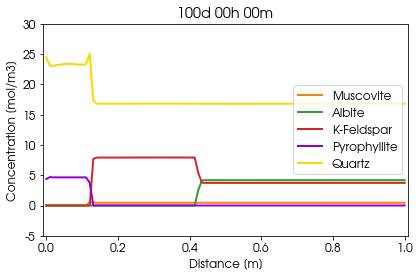

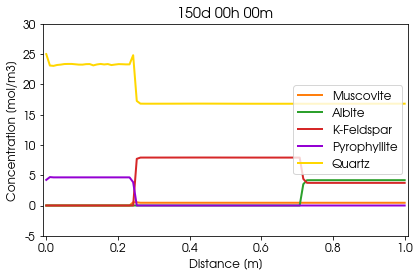

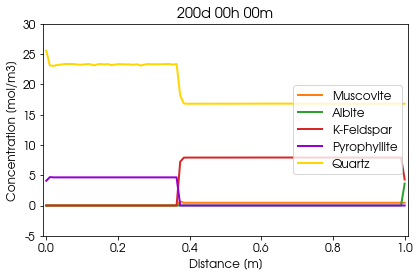

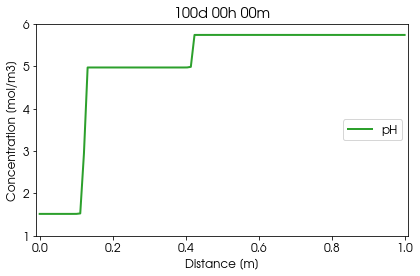

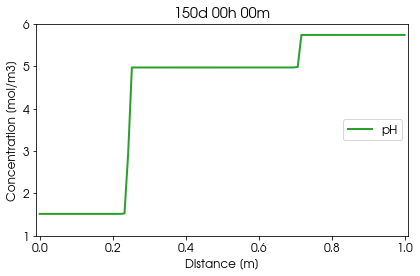

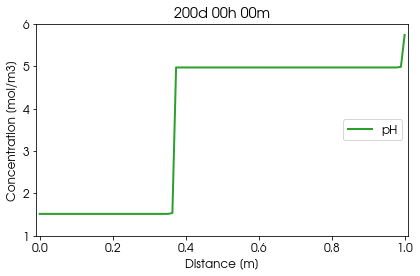

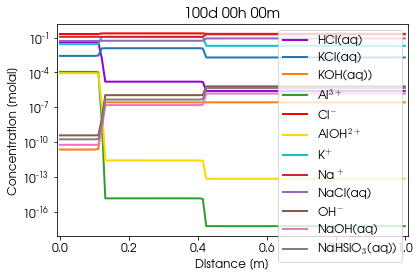

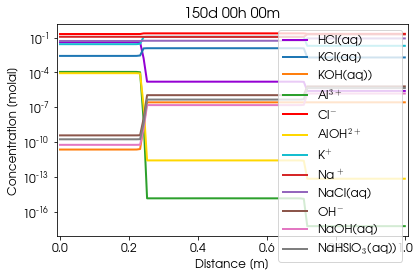

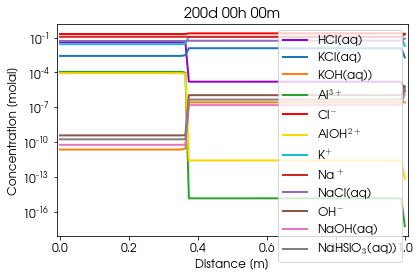

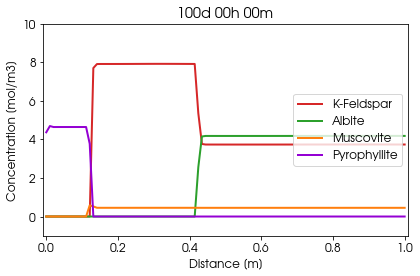

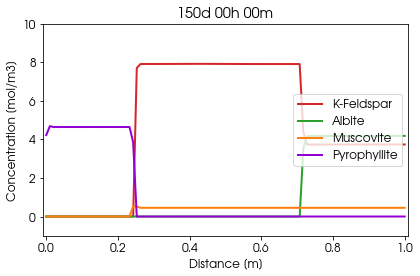

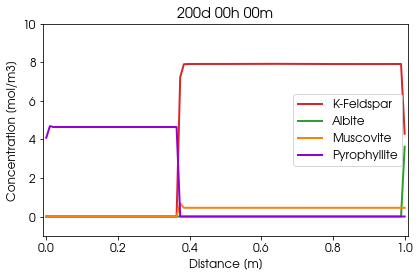

In [37]:
plot_figures_minerals()
plot_figures_ph()
plot_figures_aqueous_species()
plot_figures_kfeldspar_muscovite_albite_pyrophyllite()